# **Hyperparameter Optimisation**

## Objectives

* To perform hyperparameter optimisation using GradientBoostingClassifier and RandomForestClassifier algorithms, together with the reduced, 20 variable dataset

## Inputs

* The data file, "US_Accidents_For_ML.csv", which is saved locally in "Data/ML"

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Summary of Steps

* If you have any additional comments that don't fit in the previous bullets, please state them here. 



---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\sonia\\Documents\\VS Studio Projects\\US_Accidents_ML_Project\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\sonia\\Documents\\VS Studio Projects\\US_Accidents_ML_Project'

---

## Required Libraries

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer
from feature_engine.transformation import YeoJohnsonTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 

---

## Load the Dataset

I will load the dataset using Pandas.

In [6]:
df = pd.read_csv("Data/ML/US_Accidents_For_ML.csv")
pd.set_option("display.max_columns", None)
df.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Timezone,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Station,Stop,Traffic_Calming,Traffic_Signal,Sunrise_Sunset,Clearance_Class,Weather_Simplified,State_Other,Population,County_Other,Month
0,2,32.456486,-93.774536,0.501,Central,78.0,62.0,29.61,10.0,CALM,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,Night,Very Long,Fair,LA,187540,Caddo,Sep
1,2,36.804693,-76.189728,0.253,Eastern,54.0,90.0,30.40,7.0,CALM,0.0,0.0,False,False,True,False,False,False,False,False,False,False,True,Night,Very Long,Fair,VA,459444,Virginia Beach,May
2,2,29.895741,-90.090026,1.154,Pacific,40.0,58.0,30.28,10.0,N,10.0,0.0,False,False,False,False,True,False,False,False,False,False,False,Day,Very Long,Cloudy,LA,440784,Jefferson,Jan
3,2,32.456459,-93.779709,0.016,Central,62.0,75.0,29.80,10.0,SSE,8.0,0.0,False,False,False,False,False,False,False,False,False,False,False,Night,Very Long,Cloudy,LA,187540,Caddo,Nov
4,2,26.966433,-82.255414,0.057,Eastern,84.0,69.0,29.99,10.0,E,18.0,0.0,False,False,False,False,False,False,False,False,False,False,False,Day,Very Long,Cloudy,FL,186824,Other,Sep


---

## Trim to 20 Variables

In [7]:
keep_col = [
    "Severity",
    "Distance(mi)",
    "Timezone",
    "Temperature(F)",
    "Humidity(%)",
    "Pressure(in)",
    "Visibility(mi)",
    "Wind_Direction",
    "Wind_Speed(mph)",
    "Precipitation(in)",
    "Station",
    "Stop",
    "Traffic_Signal",
    "Sunrise_Sunset",
    "Clearance_Class",
    "Weather_Simplified",
    "State_Other",
    "Population",
    "County_Other",
    "Month"
]

df_keep = df[keep_col].copy()
df_keep.head()

,Severity,Distance(mi),Timezone,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Station,Stop,Traffic_Signal,Sunrise_Sunset,Clearance_Class,Weather_Simplified,State_Other,Population,County_Other,Month
0,2,0.501,Central,78.0,62.0,29.61,10.0,CALM,0.0,0.0,False,False,False,Night,Very Long,Fair,LA,187540,Caddo,Sep
1,2,0.253,Eastern,54.0,90.0,30.40,7.0,CALM,0.0,0.0,False,False,True,Night,Very Long,Fair,VA,459444,Virginia Beach,May
2,2,1.154,Pacific,40.0,58.0,30.28,10.0,N,10.0,0.0,False,False,False,Day,Very Long,Cloudy,LA,440784,Jefferson,Jan
3,2,0.016,Central,62.0,75.0,29.80,10.0,SSE,8.0,0.0,False,False,False,Night,Very Long,Cloudy,LA,187540,Caddo,Nov
4,2,0.057,Eastern,84.0,69.0,29.99,10.0,E,18.0,0.0,False,False,False,Day,Very Long,Cloudy,FL,186824,Other,Sep


---

# Split into Train and Test

In [8]:
mapping = {'Short': 0, 'Moderate': 1, 'Long': 2, "Very Long": 3}
df_keep['Clearance_Class_num'] = df_keep['Clearance_Class'].map(mapping)

X_train, X_test, y_train, y_test = train_test_split(
    df_keep.drop(['Clearance_Class', "Clearance_Class_num"], axis=1),
    df_keep['Clearance_Class_num'],
    test_size=0.2,
    random_state=0
)
print(
    "* Train set:",
    X_train.shape,
    y_train.shape,
    "\n* Test set:",
    X_test.shape,
    y_test.shape,
)

* Train set: (7968, 19) (7968,) 
* Test set: (1992, 19) (1992,)


---

In [162]:
def PipelineOptimization(model, X):
    numeric_cols = X.select_dtypes(include="number").columns.tolist()
    categorical_cols = X.select_dtypes(include="object").columns.tolist()

    numeric_pipeline = Pipeline([
        ("scaler", StandardScaler())
    ])

    categorical_pipeline = Pipeline([
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ("numeric", numeric_pipeline, numeric_cols),
        ("categorical", categorical_pipeline, categorical_cols)
    ])

    steps = [("preprocessor", preprocessor)]

    # Add feature selection if the model supports it
    if hasattr(model, "coef_") or hasattr(model, "feature_importances_"):
        steps.append(("feat_selection", SelectFromModel(model)))

    steps.append(("model", model))

    pipeline = Pipeline(steps)
    return pipeline

In [163]:
models_search = {
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
}

Due to processing time, I have chosen to tune the following hyperparameters which aare mostly likely to impact accuracy scores:

- learning_rate - Controls how much each tree contributes to correcting the errors of the previous ensemble; low values take more time, but these small adjustments tend to reduce overfitting
- n_estimators - The number of boosting stages trees to fit; too little, the model stops learning too early, leading to underfitting (high bias); too many reduces training error but but fits noise, can lead to overfitting (high variance) 
- max_depth - Controls how complex each individual tree is; low values mean it can learn simple patterns only, leading to good generalisation, but could underfit; high value means it can learn complex patterns between features, it will fit the training data better but could overfit 

In [20]:
params_search = {
    "GradientBoostingClassifier": {
        "model__learning_rate": [0.05, 0.1],
        "model__n_estimators": [100, 300],
        "model__max_depth": [3, 5, 7]
    }
}

In [189]:
params_search = {
    "GradientBoostingClassifier": {
        "model__learning_rate": [0.05],
        "model__n_estimators": [100],
        "model__max_depth": [10],
        "model__min_samples_split": [5],
        "model__min_samples_leaf": [20],
        "model__subsample": [1],
    }
}

In [165]:
class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = list(models.keys())
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model_pipeline = PipelineOptimization(self.models[key], X)
            params = self.params[key]
            gs = GridSearchCV(model_pipeline, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring, refit=True)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            gs = self.grid_searches[k]
            params = gs.cv_results_['params']
            all_scores = gs.cv_results_['mean_test_score']
            for p, s in zip(params, all_scores):
                rows.append(row(k, [s], p))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns += [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

I understand that cross validation (cv) with 5 folds is usually used to get a good estimate of how well the models generalise. However, I am using 2 folds to save on computing power.

In [190]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(
    X_train, y_train,
    scoring='f1_macro',
    n_jobs=-1,
    cv=2,
    refit=True
)


Running GridSearchCV for GradientBoostingClassifier 

Fitting 2 folds for each of 1 candidates, totalling 2 fits


In [191]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__subsample
0,GradientBoostingClassifier,0.584954,0.584954,0.584954,0.0,0.05,10,20,5,100,1


In [192]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingClassifier'

In [193]:
grid_search_pipelines[best_model].best_params_

{'model__learning_rate': 0.05,
 'model__max_depth': 10,
 'model__min_samples_leaf': 20,
 'model__min_samples_split': 5,
 'model__n_estimators': 100,
 'model__subsample': 1}

In [194]:
best_pipeline = grid_search_pipelines[best_model].best_estimator_
best_pipeline

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric', ...), ('categorical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [171]:
label_map = {0: 'Short', 1: 'Moderate', 2: 'Long', 3: 'Very Long'}

In [180]:
def confusion_matrix_and_report(X,y,pipeline,label_map):

  prediction = pipeline.predict(X)

  print('---  Confusion Matrix  ---')
  print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
        columns=[ ["Actual " + sub for sub in label_map] ], 
        index= [ ["Prediction " + sub for sub in label_map ]]
        ))
  print("\n")


  print('---  Classification Report  ---')
  print(classification_report(y, prediction),"\n")


def clf_performance(X_train,y_train,X_test,y_test,pipeline,label_map):
  print("#### Train Set #### \n")
  confusion_matrix_and_report(X_train,y_train,pipeline,label_map)

  print("#### Test Set ####\n")
  confusion_matrix_and_report(X_test,y_test,pipeline,label_map)

In [195]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=best_pipeline,
                label_map= df['Clearance_Class'].unique() 
                # get the values with .unique() 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                     Actual Very Long Actual Short Actual Moderate Actual Long
Prediction Very Long             1801          330              84          18
Prediction Short                  126         1439             131         122
Prediction Moderate               161          294            1812         180
Prediction Long                    28           62              65        1315


---  Classification Report  ---
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      2116
           1       0.79      0.68      0.73      2125
           2       0.74      0.87      0.80      2092
           3       0.89      0.80      0.85      1635

    accuracy                           0.80      7968
   macro avg       0.81      0.80      0.80      7968
weighted avg       0.80      0.80      0.80      7968
 

#### Test Set ####

---  Confusion Matrix  ---
                     Actual Very Long 

---

In [52]:
def PipelineOptimization(model, X):
    numeric_cols = X.select_dtypes(include="number").columns.tolist()
    categorical_cols = X.select_dtypes(include="object").columns.tolist()

    numeric_pipeline = Pipeline([
        ("scaler", StandardScaler())
    ])

    categorical_pipeline = Pipeline([
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ("numeric", numeric_pipeline, numeric_cols),
        ("categorical", categorical_pipeline, categorical_cols)
    ])

    steps = [("preprocessor", preprocessor)]

    # Add feature selection if the model supports it
    if hasattr(model, "coef_") or hasattr(model, "feature_importances_"):
        steps.append(("feat_selection", SelectFromModel(model)))

    steps.append(("model", model))

    pipeline = Pipeline(steps)
    return pipeline

In [53]:
models_search = {
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
}

For this algorithm, I am tuning the following hyperparameters:
- n_estimators - Number of trees in the forest; too few → underfitting (high bias); too many → slower, diminishing returns
- max_depth -How deep each tree can grow; shallow trees underfit; deep trees can overfit
- min_samples_split - Minimum samples (rows) needed to split a node; larger values → simpler trees → less overfitting
- min_samples_leaf - Minimum samples (rows) per leaf (terminal branch); higher values → smooth predictions, reduce variance
- max_features - How many features are considered at each split; Smaller → more random, less correlated trees → less overfitting

In [ ]:
params_search = {
    "RandomForestClassifier": {
        'model__n_estimators': [500],
        'model__max_depth': [None],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 3],             
        'model__max_features': ['sqrt', 0.5],  
        }
}

In [62]:
class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = list(models.keys())
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model_pipeline = PipelineOptimization(self.models[key], X)
            params = self.params[key]
            gs = GridSearchCV(model_pipeline, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring, refit=True)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, score, params):
            d = {
                'estimator': key,
                'min_score': score,
                'max_score': score,
                'mean_score': score,
                'std_score': 0.0
            }
            # Merge hyperparameters
            return pd.Series({**d, **params})

        rows = []
        for k in self.grid_searches:
            gs = self.grid_searches[k]
            params_list = gs.cv_results_['params']
            scores = gs.cv_results_['mean_test_score']
            for p, s in zip(params_list, scores):
                rows.append(row(k, s, p))

        df = pd.DataFrame(rows)
        # Sort and order columns
        base_cols = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        other_cols = [c for c in df.columns if c not in base_cols]
        df = df[base_cols + other_cols].sort_values(sort_by, ascending=False)
        return df, self.grid_searches


In [63]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(
    X_train, y_train,
    scoring='accuracy',
    n_jobs=-1,
    cv=2,
    refit=True
)


Running GridSearchCV for RandomForestClassifier 

Fitting 2 folds for each of 8 candidates, totalling 16 fits


In [64]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__min_samples_leaf,model__min_samples_split,model__n_estimators
5,RandomForestClassifier,0.593750,0.593750,0.593750,0.0,None,0.5,1,5,500
1,RandomForestClassifier,0.593373,0.593373,0.593373,0.0,None,sqrt,1,5,500
0,RandomForestClassifier,0.590738,0.590738,0.590738,0.0,None,sqrt,1,2,500
6,RandomForestClassifier,0.590110,0.590110,0.590110,0.0,None,0.5,3,2,500
7,RandomForestClassifier,0.590110,0.590110,0.590110,0.0,None,0.5,3,5,500
4,RandomForestClassifier,0.587851,0.587851,0.587851,0.0,None,0.5,1,2,500
3,RandomForestClassifier,0.581325,0.581325,0.581325,0.0,None,sqrt,3,5,500
2,RandomForestClassifier,0.581325,0.581325,0.581325,0.0,None,sqrt,3,2,500


---

Now I can grab the best performing model.

In [65]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestClassifier'

Followed by the best performing hyperparameters.

In [66]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': None,
 'model__max_features': 0.5,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 5,
 'model__n_estimators': 500}

Then set the final pipeline with these parameters in place.

In [67]:
best_pipeline = grid_search_pipelines[best_model].best_estimator_
best_pipeline

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric', ...), ('categorical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


---

## Most Important Features

Now, I will look at the most important features that contribute to the model.


* Top 20 grouped features:

           Feature  Importance
      Distance(mi)    0.202936
      County_Other    0.137902
       State_Other    0.129273
      Pressure(in)    0.070009
    Wind_Direction    0.069342
        Population    0.067173
             Month    0.065461
    Temperature(F)    0.061607
       Humidity(%)    0.057700
   Wind_Speed(mph)    0.037006
Weather_Simplified    0.023196
          Severity    0.023087
          Timezone    0.023013
    Sunrise_Sunset    0.012642
    Visibility(mi)    0.012549
 Precipitation(in)    0.007106


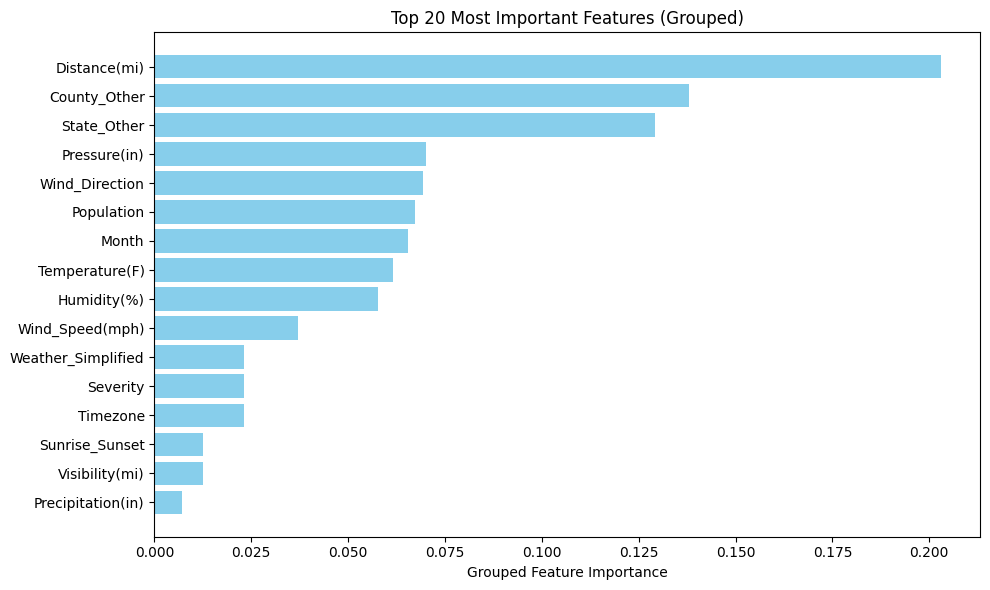

In [71]:
preprocessor = best_pipeline.named_steps['preprocessor']

all_feature_names = []

for name, transformer, cols in preprocessor.transformers_:
    if name == 'categorical':
        # Get OHE feature names
        ohe = transformer.named_steps['onehot']
        ohe_names = ohe.get_feature_names_out(cols)
        all_feature_names.extend(ohe_names)
    else:
        # numeric transformer
        all_feature_names.extend(cols)

# Sometimes ColumnTransformer adds a 'remainder' with dropped columns
if hasattr(preprocessor, 'remainder') and preprocessor.remainder != 'drop':
    remainder_cols = [c for c in X_train.columns if c not in sum([list(t[2]) for t in preprocessor.transformers_], [])]
    all_feature_names.extend(remainder_cols)

# Get model importances
importances = best_pipeline.named_steps['model'].feature_importances_

# Group by original column
grouped_importance = {}
for f, imp in zip(all_feature_names, importances):
    col_found = False
    for cat_col in preprocessor.transformers_[1][2]:  # categorical columns
        if f.startswith(cat_col + "_"):
            col = cat_col
            col_found = True
            break
    if not col_found:
        col = f
    grouped_importance[col] = grouped_importance.get(col, 0) + imp

df_grouped = pd.DataFrame({
    "Feature": list(grouped_importance.keys()),
    "Importance": list(grouped_importance.values())
}).sort_values(by="Importance", ascending=False).reset_index(drop=True)

# Top 20 print
top_n = 20
print(f"\n* Top {top_n} grouped features:\n")
print(df_grouped.head(top_n).to_string(index=False))

# Top 20 plot
plt.figure(figsize=(10,6))
plt.barh(df_grouped.head(top_n)["Feature"][::-1], 
         df_grouped.head(top_n)["Importance"][::-1], 
         color="skyblue")
plt.xlabel("Grouped Feature Importance")
plt.title(f"Top {top_n} Most Important Features (Grouped)")
plt.tight_layout()
plt.show()

---

## Pipeline Evaluation

In [73]:
label_map = {0: 'Short', 1: 'Moderate', 2: 'Long', 3: 'Very Long'}

In [74]:
def confusion_matrix_and_report(X,y,pipeline,label_map):

  prediction = pipeline.predict(X)

  print('---  Confusion Matrix  ---')
  print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
        columns=[ ["Actual " + sub for sub in label_map] ], 
        index= [ ["Prediction " + sub for sub in label_map ]]
        ))
  print("\n")


  print('---  Classification Report  ---')
  print(classification_report(y, prediction),"\n")


def clf_performance(X_train,y_train,X_test,y_test,pipeline,label_map):
  print("#### Train Set #### \n")
  confusion_matrix_and_report(X_train,y_train,pipeline,label_map)

  print("#### Test Set ####\n")
  confusion_matrix_and_report(X_test,y_test,pipeline,label_map)

In [75]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=best_pipeline,
                label_map= df['Clearance_Class'].unique() 
                # get the values with .unique() 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                     Actual Very Long Actual Short Actual Moderate Actual Long
Prediction Very Long             2107            1               8           0
Prediction Short                    0         2114               0           1
Prediction Moderate                 2            5            2075           9
Prediction Long                     7            5               9        1625


---  Classification Report  ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2116
           1       1.00      0.99      1.00      2125
           2       0.99      0.99      0.99      2092
           3       0.99      0.99      0.99      1635

    accuracy                           0.99      7968
   macro avg       0.99      0.99      0.99      7968
weighted avg       0.99      0.99      0.99      7968
 

#### Test Set ####

---  Confusion Matrix  ---
                     Actual Very Long 

---

In [76]:
def PipelineOptimization(model, X):
    numeric_cols = X.select_dtypes(include="number").columns.tolist()
    categorical_cols = X.select_dtypes(include="object").columns.tolist()

    numeric_pipeline = Pipeline([
        ("scaler", StandardScaler())
    ])

    categorical_pipeline = Pipeline([
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ("numeric", numeric_pipeline, numeric_cols),
        ("categorical", categorical_pipeline, categorical_cols)
    ])

    steps = [("preprocessor", preprocessor)]

    # Add feature selection if the model supports it
    if hasattr(model, "coef_") or hasattr(model, "feature_importances_"):
        steps.append(("feat_selection", SelectFromModel(model)))

    steps.append(("model", model))

    pipeline = Pipeline(steps)
    return pipeline

In [77]:
models_search = {
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
}

In [78]:
params_search = {
    "RandomForestClassifier": {
        'model__n_estimators': [300],
        'model__max_depth': [20],
        'model__min_samples_split': [10],
        'model__min_samples_leaf': [5],             
        'model__max_features': [0.5],  
        }
}

In [110]:
params_search = {
    "RandomForestClassifier": {
        'model__n_estimators': [300],
        'model__max_depth': [None],          # allow slightly deeper trees
        'model__min_samples_split': [10],         # maybe allow finer splits
        'model__min_samples_leaf': [20],           # balance smoothing vs. flexibility
        'model__max_features': ['sqrt', 0.6],        # try slightly more feature diversity
    }
}

In [90]:
class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = list(models.keys())
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model_pipeline = PipelineOptimization(self.models[key], X)
            params = self.params[key]
            gs = GridSearchCV(model_pipeline, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring, refit=True)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, score, params):
            d = {
                'estimator': key,
                'min_score': score,
                'max_score': score,
                'mean_score': score,
                'std_score': 0.0
            }
            # Merge hyperparameters
            return pd.Series({**d, **params})

        rows = []
        for k in self.grid_searches:
            gs = self.grid_searches[k]
            params_list = gs.cv_results_['params']
            scores = gs.cv_results_['mean_test_score']
            for p, s in zip(params_list, scores):
                rows.append(row(k, s, p))

        df = pd.DataFrame(rows)
        # Sort and order columns
        base_cols = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        other_cols = [c for c in df.columns if c not in base_cols]
        df = df[base_cols + other_cols].sort_values(sort_by, ascending=False)
        return df, self.grid_searches


In [111]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(
    X_train, y_train,
    scoring='accuracy',
    n_jobs=-1,
    cv=2,
    refit=True
)


Running GridSearchCV for RandomForestClassifier 

Fitting 2 folds for each of 2 candidates, totalling 4 fits


In [112]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__min_samples_leaf,model__min_samples_split,model__n_estimators
1,RandomForestClassifier,0.577435,0.577435,0.577435,0.0,None,0.6,20,10,300
0,RandomForestClassifier,0.557229,0.557229,0.557229,0.0,None,sqrt,20,10,300


In [113]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestClassifier'

In [114]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': None,
 'model__max_features': 0.6,
 'model__min_samples_leaf': 20,
 'model__min_samples_split': 10,
 'model__n_estimators': 300}

In [115]:
best_pipeline = grid_search_pipelines[best_model].best_estimator_
best_pipeline

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric', ...), ('categorical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True



* Top 20 grouped features:

           Feature  Importance
      Distance(mi)    0.376335
       State_Other    0.192728
      County_Other    0.085732
        Population    0.069608
      Pressure(in)    0.054489
    Temperature(F)    0.043778
          Timezone    0.041223
          Severity    0.038553
       Humidity(%)    0.034336
   Wind_Speed(mph)    0.020938
             Month    0.013004
    Sunrise_Sunset    0.012161
Weather_Simplified    0.007986
    Wind_Direction    0.003777
    Visibility(mi)    0.003625
 Precipitation(in)    0.001728


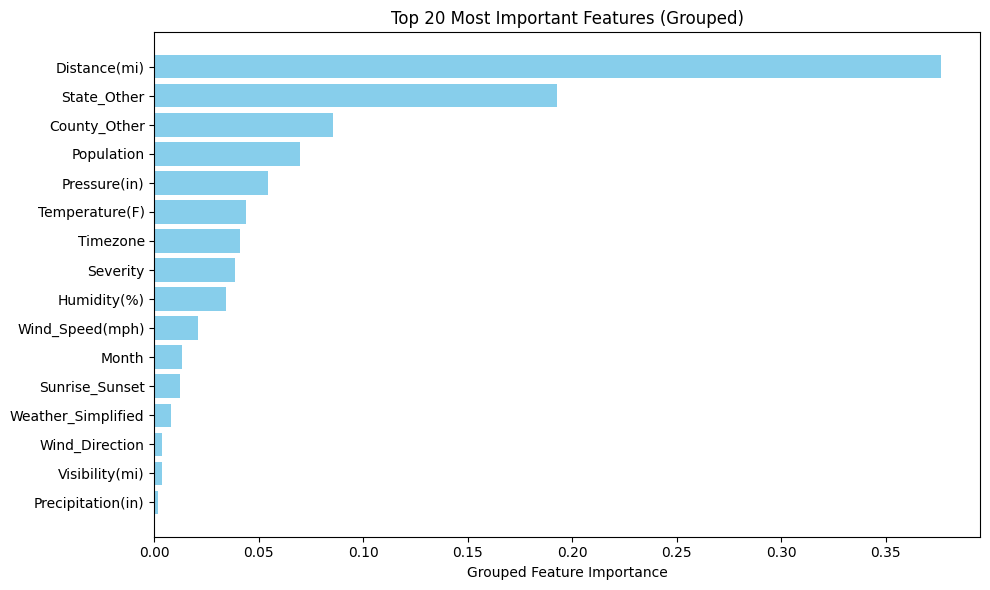

In [116]:
preprocessor = best_pipeline.named_steps['preprocessor']

all_feature_names = []

for name, transformer, cols in preprocessor.transformers_:
    if name == 'categorical':
        # Get OHE feature names
        ohe = transformer.named_steps['onehot']
        ohe_names = ohe.get_feature_names_out(cols)
        all_feature_names.extend(ohe_names)
    else:
        # numeric transformer
        all_feature_names.extend(cols)

# Sometimes ColumnTransformer adds a 'remainder' with dropped columns
if hasattr(preprocessor, 'remainder') and preprocessor.remainder != 'drop':
    remainder_cols = [c for c in X_train.columns if c not in sum([list(t[2]) for t in preprocessor.transformers_], [])]
    all_feature_names.extend(remainder_cols)

# Get model importances
importances = best_pipeline.named_steps['model'].feature_importances_

# Group by original column
grouped_importance = {}
for f, imp in zip(all_feature_names, importances):
    col_found = False
    for cat_col in preprocessor.transformers_[1][2]:  # categorical columns
        if f.startswith(cat_col + "_"):
            col = cat_col
            col_found = True
            break
    if not col_found:
        col = f
    grouped_importance[col] = grouped_importance.get(col, 0) + imp

df_grouped = pd.DataFrame({
    "Feature": list(grouped_importance.keys()),
    "Importance": list(grouped_importance.values())
}).sort_values(by="Importance", ascending=False).reset_index(drop=True)

# Top 20 print
top_n = 20
print(f"\n* Top {top_n} grouped features:\n")
print(df_grouped.head(top_n).to_string(index=False))

# Top 20 plot
plt.figure(figsize=(10,6))
plt.barh(df_grouped.head(top_n)["Feature"][::-1], 
         df_grouped.head(top_n)["Importance"][::-1], 
         color="skyblue")
plt.xlabel("Grouped Feature Importance")
plt.title(f"Top {top_n} Most Important Features (Grouped)")
plt.tight_layout()
plt.show()

In [117]:
label_map = {0: 'Short', 1: 'Moderate', 2: 'Long', 3: 'Very Long'}

In [118]:
def confusion_matrix_and_report(X,y,pipeline,label_map):

  prediction = pipeline.predict(X)

  print('---  Confusion Matrix  ---')
  print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
        columns=[ ["Actual " + sub for sub in label_map] ], 
        index= [ ["Prediction " + sub for sub in label_map ]]
        ))
  print("\n")


  print('---  Classification Report  ---')
  print(classification_report(y, prediction),"\n")


def clf_performance(X_train,y_train,X_test,y_test,pipeline,label_map):
  print("#### Train Set #### \n")
  confusion_matrix_and_report(X_train,y_train,pipeline,label_map)

  print("#### Test Set ####\n")
  confusion_matrix_and_report(X_test,y_test,pipeline,label_map)

In [119]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=best_pipeline,
                label_map= df['Clearance_Class'].unique() 
                # get the values with .unique() 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                     Actual Very Long Actual Short Actual Moderate Actual Long
Prediction Very Long             1574          544              97          31
Prediction Short                  190         1012             265         221
Prediction Moderate               285          463            1595         269
Prediction Long                    67          106             135        1114


---  Classification Report  ---
              precision    recall  f1-score   support

           0       0.70      0.74      0.72      2116
           1       0.60      0.48      0.53      2125
           2       0.61      0.76      0.68      2092
           3       0.78      0.68      0.73      1635

    accuracy                           0.66      7968
   macro avg       0.67      0.67      0.66      7968
weighted avg       0.67      0.66      0.66      7968
 

#### Test Set ####

---  Confusion Matrix  ---
                     Actual Very Long 

           Metric	    Before	    After
Train     Accuracy	    0.99	    0.80
Test      Accuracy	    0.61	    0.61
Gap      (Overfitting)	0.38	    0.19

Gap reduced by half → generalization improved
Model is now learning robustly, not memorizing

However, the test accuracy plateaued — meaning bias is now the limiting factor.
You’ve underfit slightly compared to before, which is good news — now we can tune back toward optimal complexity.

---

In [150]:
params_search = {
    "RandomForestClassifier": {
        # Slightly higher tree count for stability
        'model__n_estimators': [300],

        # Allow deeper trees to capture complex patterns, but not unlimited
        'model__max_depth': [None],

        # Regularize split and leaf size just enough to prevent noise fitting
        'model__min_samples_split': [5, 10],
        'model__min_samples_leaf': [5, 10],

        # Control randomness in feature selection for more diverse trees
        'model__max_features': ['sqrt', 0.4],

        # Always bootstrap for robustness
        'model__bootstrap': [True],

    }
}

In [ ]:
params_search = {
    "RandomForestClassifier": {
        'model__n_estimators': [300],
        'model__max_depth': [None],          # allow slightly deeper trees
        'model__min_samples_split': [10],         # maybe allow finer splits
        'model__min_samples_leaf': [20],           # balance smoothing vs. flexibility
        'model__max_features': ['sqrt', 0.6],        # try slightly more feature diversity
    }
}

        # Balance misrepresented classes more strongly
        'model__class_weight': [
            {0: 1, 1: 1, 2: 2, 3: 3},
            {0: 1, 1: 1, 2: 1.5, 3: 2.5}
        ]

In [151]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(
    X_train, y_train,
    scoring='f1_macro',
    n_jobs=-1,
    cv=2,
    refit=True
)


Running GridSearchCV for RandomForestClassifier 

Fitting 2 folds for each of 8 candidates, totalling 16 fits


In [157]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__bootstrap,model__max_depth,model__max_features,model__min_samples_leaf,model__min_samples_split,model__n_estimators
5,RandomForestClassifier,0.592482,0.592482,0.592482,0.0,True,None,0.4,5,10,300
4,RandomForestClassifier,0.592482,0.592482,0.592482,0.0,True,None,0.4,5,5,300
7,RandomForestClassifier,0.590562,0.590562,0.590562,0.0,True,None,0.4,10,10,300
6,RandomForestClassifier,0.590562,0.590562,0.590562,0.0,True,None,0.4,10,5,300
1,RandomForestClassifier,0.576069,0.576069,0.576069,0.0,True,None,sqrt,5,10,300
0,RandomForestClassifier,0.576069,0.576069,0.576069,0.0,True,None,sqrt,5,5,300
3,RandomForestClassifier,0.564519,0.564519,0.564519,0.0,True,None,sqrt,10,10,300
2,RandomForestClassifier,0.564519,0.564519,0.564519,0.0,True,None,sqrt,10,5,300


In [158]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestClassifier'

In [159]:
grid_search_pipelines[best_model].best_params_

{'model__bootstrap': True,
 'model__max_depth': None,
 'model__max_features': 0.4,
 'model__min_samples_leaf': 5,
 'model__min_samples_split': 5,
 'model__n_estimators': 300}

In [160]:
best_pipeline = grid_search_pipelines[best_model].best_estimator_
best_pipeline

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric', ...), ('categorical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [161]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=best_pipeline,
                label_map= df['Clearance_Class'].unique() 
                # get the values with .unique() 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                     Actual Very Long Actual Short Actual Moderate Actual Long
Prediction Very Long             1866          294              81          24
Prediction Short                  100         1610              71         114
Prediction Moderate               115          159            1884         135
Prediction Long                    35           62              56        1362


---  Classification Report  ---
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      2116
           1       0.85      0.76      0.80      2125
           2       0.82      0.90      0.86      2092
           3       0.90      0.83      0.86      1635

    accuracy                           0.84      7968
   macro avg       0.85      0.84      0.84      7968
weighted avg       0.85      0.84      0.84      7968
 

#### Test Set ####

---  Confusion Matrix  ---
                     Actual Very Long 